In [27]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [28]:
cd drive/My Drive/kogaken/mlphase

[Errno 2] No such file or directory: 'drive/My Drive/kogaken/mlphase'
/content/drive/My Drive/kogaken/mlphase


In [29]:
# coding: utf-8
# import subprocess

import sys
import os
import numpy as np
import json
import pickle
from datetime import datetime
# import itertools
import matplotlib.pyplot as plt
import random

# from making_2D_image_20191028 import load_data
# from making_2D_image_20191028 import surf_figure, reduce_pkl_data

# from common.simple_convnet import SimpleConvNet
# from common.trainer import Trainer
# from dataset.mnist import load_mnist
# import matplotlib as mpl

In [30]:
import tensorflow as tf

from tensorflow.python.keras.utils.vis_utils import plot_model

from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from keras.callbacks import CSVLogger, EarlyStopping
# from keras.datasets import mnist
# from keras.layers import Activation, Dropout, Reshape, SeparableConv2D
# from keras.callbacks import EarlyStopping

# from file_operation import MAKE_DIR, COPY_FILES

# sys.path.append(os.pardir)

In [76]:
def make_fig_one_pair_abs(x, sfolder, text=""):
    temp1 = np.random.randint(0, np.shape(x[0])[0], size=4)

    n = len(x)
    print(np.shape(x[0]))
    fig = plt.figure()
    for i, j in enumerate(temp1):
        for k in range(n):
            ax = fig.add_subplot(4, n, (n * i) + k + 1)
            # ax.set_title("in")
            ax.set_xticks([], minor=False)
            ax.set_yticks([], minor=False)
            ax.imshow(np.abs(x[k][j, 0, :, :]))

    file = sfolder + "/" + "in_out_figs_" + text + "_".join(str(temp1)) + ".png"
    print(file)
    plt.savefig(file)
    plt.close()

In [77]:
def history_fig(history, file_train, sfolder):
    epochs = range(len(history.history['accuracy']))
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='training')
    plt.plot(epochs, history.history['val_accuracy'], label='validation')
    plt.title('accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='training')
    plt.plot(epochs, history.history['val_loss'], label='validation')
    plt.title('loss(MSE)')
    plt.ylim([0, 0.05])
    plt.legend()
    plt.savefig(sfolder + "/" + os.path.basename(file_train).split(".")[0] + '.png')


In [78]:
def save_model(model, file_train, sfolder):
    file = sfolder + "/" + "model_tree.png"
    print("save_file:", file)
    plot_model(model, to_file=file, show_shapes=True)
    # model.summary()

In [79]:
def reshape_complex(x, mode="abs_phase", normalize=True):

    if normalize:
        x = x / np.max(np.abs(x))

    if ("complex" in str(type(x[0, 0, 0, 0]))):
        if mode == "abs_phase":
            x = reshape_complex_to_abs_phase(x, axis=1)
            if normalize:
                x[:, 1, :, :] = (x[:, 1, :, :] + np.pi) / (2. * np.pi)
        if mode == "abs":
            x = np.abs(x)
        if mode == "real_imag":
            x = reshape_complex_to_real_imag(x, axis=1)
    return x


def reshape_complex_to_real_imag(x, axis=1):
    """RealとImag"""

    return np.append(np.real(x), np.imag(x), axis=axis)


def reshape_complex_to_abs_phase(x, axis=1):
    """絶対値と偏角"""

    return np.append(np.abs(x), np.angle(x), axis=axis)

In [80]:
def load_data_2(file1, file2):

    new_file = os.path.dirname(file1) + "/" \
        + os.path.basename(file1).split(".")[0] + "_" \
        + os.path.basename(file2).split(".")[0] + "_"

    if not os.path.isfile(new_file):
        print("make combined file: ", new_file)
        new_file, data_num = combine_pkl_data(file1, file2, new_file)

    print("load_data of input", file1, file2)
    print("load_data:", new_file)

    with open(new_file, "rb") as f:
        data = pickle.load(f)

    z1, z2, t = [], [], []

    for d in data:
        z1.append([d["z1"]])
        z2.append([d["z2"]])
        t.append([d["info"]])

    z1 = np.array(z1)
    z2 = np.array(z2)
    t = np.array(t)
    return z1, z2, t, data_num

In [81]:
def load_data(*files):
    # if len(files) == 1:
    #     return load_data_1(files[0], num_data=num_data)
    # elif len(files) == 2:
    #     return load_data_2(files[0], files[1])
    if len(files) == 2:
        return load_data_2(files[0], files[1])
    else:
        print("No Two files!!")
        exit()

In [82]:
def combine_pkl_data(file1, file2, new_file):

    with open(file1, "rb") as f:
        detec_data = pickle.load(f)
    with open(file2, "rb") as f:
        mirror_data = pickle.load(f)

    i = 0
    data = []
    for e_data in mirror_data["elip"]:
        row = {
            "info": detec_data[i]["info"],
            "z1": detec_data[i]["z"],
            "z2": e_data["z"]
        }
        i += 1
        data.append(row)

    for m_data in mirror_data["mode"]:
        row = {
            "info": detec_data[i]["info"],
            "z1": detec_data[i]["z"],
            "z2": m_data["z"]
        }
        i += 1
        data.append(row)

    new_file += str(i) + ".pkl"

    with open(new_file, 'wb') as f:
        pickle.dump(data, f)

    return new_file, i

In [83]:
def regressin_CNN(x, y, xt, yt, sfolder, active_function="relu"):
    x = np.array(x)
    y = np.array(y)
    xt = np.array(xt)
    yt = np.array(yt)

    x = np.transpose(x, (0, 2, 3, 1))
    xt = np.transpose(xt, (0, 2, 3, 1))
    y = np.transpose(y, (0, 2, 3, 1))
    yt = np.transpose(yt, (0, 2, 3, 1))

    print("")
    print("check point 3")
    for s in [x, y, xt, yt]:
        print(np.shape(s))

    ydim = np.shape(y)
    out_dim = ydim[1] * ydim[2] * ydim[3]
    y = y.reshape(-1, out_dim)
    yt = yt.reshape(-1, out_dim)

    print("")
    print("check point 4")
    for s in [x, y, xt, yt]:
        print(np.shape(s))
        

    model = Sequential()
    model.add(Input(shape=(16, 16, 2)))
    model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
    
    model.add(Flatten())

    model.add(Dense(8192, activation="relu"))
    model.add(Dropout(0.25))
    model.add(Dense(8192, activation="relu"))
    model.add(Dropout(0.25))

    model.add(Dense(out_dim))

    model.compile(optimizer='rmsprop',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    history = model.fit(x=x,
                        y=y,
                        epochs=10,
                        validation_data=(xt, yt),
                        verbose=2,
                        callbacks=[EarlyStopping(monitor="val_loss", 
                                                 patience=20, 
                                                 verbose=1)]
                        )
    y_pred = model.predict(xt)

    # print(history.history)

    file = "learning"
    history_fig(history, file, sfolder)
    # save_history(history, file, sfolder)
    save_model(model, file, sfolder)
    # save_components_fit(yt, y_pred, sfolder)
    # save_components_fit_9(yt, y_pred, sfolder)
    epochs = len(history.history['accuracy'])

    score = model.evaluate(x=xt, y=yt)
    rmse_score = np.sqrt(np.mean((yt - y_pred) ** 2))
    mae_score = np.mean(np.sqrt((yt - y_pred) ** 2))
    print("test_MSE: ", score[0])
    print("test_RMSE: ", rmse_score)
    print("test_MAE: ", mae_score)
    print("test_ACC: ", score[1])

    return rmse_score, mae_score, score, y_pred, epochs

In [84]:
def main_regression_CNN_learn(detec_train, mirror_train, detec_test, mirror_test, 
                              sfolder, active_function, reshape_type):
    x, y, _, train_num = load_data(detec_train, mirror_train)
    xt, yt, _, test_num = load_data(detec_test, mirror_test)

    print("")
    print("check point 1")
    for s in [x, y, xt, yt]:
        print(np.shape(s))

    x = reshape_complex(x, mode=reshape_type, normalize=True)
    y = reshape_complex(y, mode=reshape_type, normalize=True)
    xt = reshape_complex(xt, mode=reshape_type, normalize=True)
    yt = reshape_complex(yt, mode=reshape_type, normalize=True)

    print("")
    print("check point 2")
    for s in [x, y, xt, yt]:
        print(np.shape(s))

    rmse_score, mae_score, score, y_pred, epochs = regressin_CNN(x, y, xt, yt, sfolder,
                                                                active_function)

    y_pred_2d = y_pred.reshape(-1, 1, np.shape(yt)[2], np.shape(yt)[3])

    for i in range(10):
        make_fig_one_pair_abs((xt, yt, y_pred_2d), sfolder, "pred")
    
    file = sfolder + "/output.json"
    with open(file, "w") as f:
        memo = {
                "train_data_num": str(train_num),
                "test_data_num": str(test_num),
                "epochs": str(epochs),
                "test_MSE": str(score[0]),
                "test_RMSE": str(rmse_score),
                "test_MAE": str(mae_score),
                "test_ACC": str(score[1]),
                "active_func": str(active_function),
                "reshape_type": str(reshape_type)
                }
        json.dump(memo, f, indent=4)

In [85]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [86]:
def main(data_folder, active_function, reshape_type):
    strtime = datetime.now().strftime("%Y%m%d%H%M" + "-" + "%S")
    print("")
    print("time=", strtime)

    # 保存フォルダの指定,時刻がフォルダの名前になる
    if not data_folder:
        os.makedirs(strtime)
        sfolder = strtime
    else:
        sfolder = data_folder + "/" + strtime
        os.makedirs(sfolder)

    mirror_train = data_folder + "/" + "mirror_train_data.pkl"
    detec_train = data_folder + "/" + "detec_train_data.pkl"

    mirror_test = data_folder + "/" + "mirror_test_data.pkl"
    detec_test = data_folder + "/" + "detec_test_data.pkl"

    # main_make_figs(file_train_x,file_train_y,sfolder,num_data=num_data)

    # main_learn(file_train_x,file_test,sfolder,num_data)
    
    # main_regression_learn(file_train_x,file_train_y,
    #                       file_test_x, file_test_y,
    #                       sfolder,num_data=num_data)

    seed_everything(43)

    main_regression_CNN_learn(detec_train, mirror_train,
                              detec_test, mirror_test, sfolder,
                              active_function, reshape_type)


time= 202010221315-53
make combined file:  result/2020_0925_164455_implement_gaussian/detec_train_data_mirror_train_data_
load_data of input result/2020_0925_164455_implement_gaussian/detec_train_data.pkl result/2020_0925_164455_implement_gaussian/mirror_train_data.pkl
load_data: result/2020_0925_164455_implement_gaussian/detec_train_data_mirror_train_data_5000.pkl
make combined file:  result/2020_0925_164455_implement_gaussian/detec_test_data_mirror_test_data_
load_data of input result/2020_0925_164455_implement_gaussian/detec_test_data.pkl result/2020_0925_164455_implement_gaussian/mirror_test_data.pkl
load_data: result/2020_0925_164455_implement_gaussian/detec_test_data_mirror_test_data_100.pkl

check point 1
(5000, 1, 16, 16)
(5000, 1, 64, 64)
(100, 1, 16, 16)
(100, 1, 64, 64)

check point 2
(5000, 2, 16, 16)
(5000, 1, 64, 64)
(100, 2, 16, 16)
(100, 1, 64, 64)

check point 3
(5000, 16, 16, 2)
(5000, 64, 64, 1)
(100, 16, 16, 2)
(100, 64, 64, 1)

check point 4
(5000, 16, 16, 2)
(500

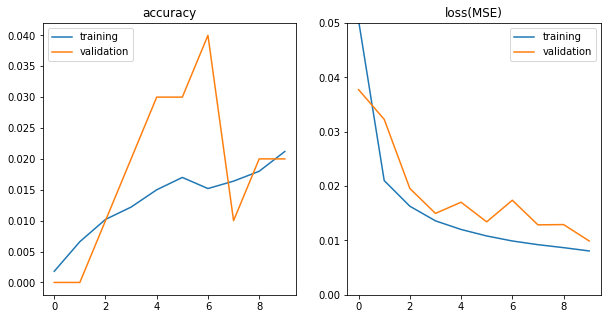

In [87]:
folder = "result/2020_0925_164455_implement_gaussian"
active_function="relu"
reshape_type='real_imag'

main(folder, active_function, reshape_type)